In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [3]:
import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# @qn - why do I need to keep track of ALL of the user input. Rather why is there a need to keep it separate
# from the main AgentState
class AgentInputState(MessagesState):
  """Input state for the full agent - only contains messages from user input."""
  pass

class AgentState(MessagesState):
  """
  Main state for the full multi-agent research system.
    
  Extends MessagesState with additional fields for research coordination.
  Note: Some fields are duplicated across different state classes for proper
  state management between subgraphs and the main workflow.
  """  
  
  # Generated from user conversation history
  research_brief: Optional[str]

  # Messages exchanged with the supervisor agent for coordination
  # @note - this agent state contains so many things
  supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]  
  
  # Raw unprocessed research notes collected during the research phase
  # @note - operator.add here CONCATS the array
  raw_notes: Annotated[list[str], operator.add] = []

  # Processed and structured notes ready for report generation
  notes: Annotated[list[str], operator.add] = []

  # Final formatted research report
  final_report: str

# @note - seems like a zod thing
class ClarifyWithUser(BaseModel):
  """Schema for user clarification decision and questions."""
    
  need_clarification: bool = Field(
      description="Whether the user needs to be asked a clarifying question.",
  )
  question: str = Field(
      description="A question to ask the user to clarify the report scope",
  )
  verification: str = Field(
      description="Verify message that we will start research after the user has provided the necessary information.",
  )
  
class ResearchQuestion(BaseModel):
  """Schema for structured research brief generation"""
  
  research_brief: str = Field(
    description="A research question that will be used to guide the research"
  )

In [ ]:
"""User Clarification and Research Brief Generation.

This module implements the scoping phase of the research workflow, where we:
1. Assess if the user's request needs clarification
2. Generate a detailed research brief from the conversation

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with research.
"""

from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

# ===== CONFIGURATION =====

# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)

# @note - a node that determines if it should continue writing or end it
def clarify_with_user_node(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
  """
  Determine if the user's request contains sufficient information to proceed with research.
    
  Uses structured output to make deterministic decisions and avoid hallucination.
  Routes to either research brief generation or ends with a clarification question.
  """
  
  structured_output_model = model.with_structured_output(ClarifyWithUser)

  CLARIFY_WITH_USER_INSTRUCTIONS=f"""
  These are the messages that have been exchanged so far from the user asking for the report:
  <Messages>
  {get_buffer_string(messages=state.get('messages', []))}
  </Messages>

  Today's date is {get_today_str()}.

  Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.
  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.

  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.
  If you need to ask a question, follow these guidelines:
  - Be concise while gathering all necessary information
  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured manner.
  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown formatting and will be rendered correctly if the string output is passed to a markdown renderer.
  - Don't ask for unnecessary information, or information that the user has already provided. If you can see that the user has already provided the information, do not ask for it again.

  Respond in valid JSON format with these exact keys:
  "need_clarification": boolean,
  "question": "<question to ask the user to clarify the report scope>",
  "verification": "<verification message that we will start research>"

  If you need to ask a clarifying question, return:
  "need_clarification": true,
  "question": "<your clarifying question>",
  "verification": ""

  If you do not need to ask a clarifying question, return:
  "need_clarification": false,
  "question": "",
  "verification": "<acknowledgement message that you will now start research based on the provided information>"

  For the verification message when no clarification is needed:
  - Acknowledge that you have sufficient information to proceed
  - Briefly summarize the key aspects of what you understand from their request
  - Confirm that you will now begin the research process
  - Keep the message concise and professional
  """
  
  response = structured_output_model.invoke([
    HumanMessage(content=CLARIFY_WITH_USER_INSTRUCTIONS)
  ])

  # @qn why does it end? when it requires information from the user
  # @ans By ending it, the user can 'reply' to the agent
  if response.need_clarification:
    return Command(
      goto=END,
      update={ "messages": [AIMessage(content=response.question)] }
    )
  else:
    return Command(
      goto="write_research_brief",
      update={"messages": [AIMessage(content=response.verification)]}
    )

def write_research_brief_node(state: AgentState):
  """
  Transform the conversation history into a comprehensive research brief.
    
  Uses structured output to ensure the brief follows the required format
  and contains all necessary details for effective research.
  """ 
  
  structured_output_model = model.with_structured_output(ResearchQuestion)
  TRANSFORM_MESSAGES_INTO_RESEARCH_TOPIC_PROMPT = f"""
  You will be given a set of messages that have been exchanged so far between yourself and the user. 
  Your job is to translate these messages into a more detailed and concrete research question that will be used to guide the research.

  The messages that have been exchanged so far between yourself and the user are:
  <Messages>
  {get_buffer_string(messages=state.get('messages', []))}
  </Messages>

  Today's date is {get_today_str()}.

  You will return a single research question that will be used to guide the research.

  Guidelines:
  1. Maximize Specificity and Detail
  - Include all known user preferences and explicitly list key attributes or dimensions to consider.
  - It is important that all details from the user are included in the instructions.

  2. Handle Unstated Dimensions Carefully
  - When research quality requires considering additional dimensions that the user hasn't specified, acknowledge them as open considerations rather than assumed preferences.
  - Example: Instead of assuming "budget-friendly options," say "consider all price ranges unless cost constraints are specified."
  - Only mention dimensions that are genuinely necessary for comprehensive research in that domain.

  3. Avoid Unwarranted Assumptions
  - Never invent specific user preferences, constraints, or requirements that weren't stated.
  - If the user hasn't provided a particular detail, explicitly note this lack of specification.
  - Guide the researcher to treat unspecified aspects as flexible rather than making assumptions.

  4. Distinguish Between Research Scope and User Preferences
  - Research scope: What topics/dimensions should be investigated (can be broader than user's explicit mentions)
  - User preferences: Specific constraints, requirements, or preferences (must only include what user stated)
  - Example: "Research coffee quality factors (including bean sourcing, roasting methods, brewing techniques) for San Francisco coffee shops, with primary focus on taste as specified by the user."

  5. Use the First Person
  - Phrase the request from the perspective of the user.

  6. Sources
  - If specific sources should be prioritized, specify them in the research question.
  - For product and travel research, prefer linking directly to official or primary websites (e.g., official brand sites, manufacturer pages, or reputable e-commerce platforms like Amazon for user reviews) rather than aggregator sites or SEO-heavy blogs.
  - For academic or scientific queries, prefer linking directly to the original paper or official journal publication rather than survey papers or secondary summaries.
  - For people, try linking directly to their LinkedIn profile, or their personal website if they have one.
  - If the query is in a specific language, prioritize sources published in that language.
  """

  response = structured_output_model.invoke([
    HumanMessage(content=TRANSFORM_MESSAGES_INTO_RESEARCH_TOPIC_PROMPT)
  ])

  return {
    "research_brief": response.research_brief,
    "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
  }

deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user_node)
deep_researcher_builder.add_node("write_research_brief", write_research_brief_node)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Compile the workflow
scope_research = deep_researcher_builder.compile()

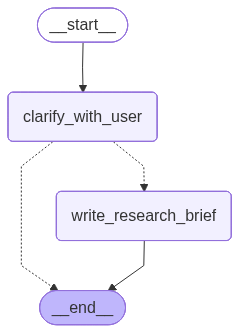

In [7]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [8]:
from utils import format_messages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in coffee quality, ambiance, Wi-Fi availability, food options, or something else?   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = scope.invoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you please specify what criteria are most important to you when determining the 'best' coffee shops? For  │
│ example, are you interested in coffee quality, ambiance, Wi-Fi availability, food options, or something else?   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that coffee quality is the primary criterion for assessing the best coffee shops in    │
│ San Francisco. I will now begin researching and compiling a list of top coffee shops in San Francisco based on  │
│ their coffee quality.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

I want to identify the best coffee shops in San Francisco, focusing specifically on coffee quality as the primary  
criterion. Please research and compare coffee shops in San Francisco based on factors that contribute to coffee    
quality, such as bean sourcing, roasting methods, brewing techniques, and taste. Other aspects like ambiance, Wi-Fi
availability, food options, and price are not specified as important for this research and can be treated as open  
considerations. Unless otherwise noted, consider all types of coffee shops regardless of price range or location   
within San Francisco. When possible, prioritize information from official coffee shop websites, reputable specialty
coffee publications, and direct customer reviews on primary platforms (such as Google Reviews or Yelp) to assess   
coffee quality.

# Evaluation From Onwards!

In [11]:
from langchain_core.messages import AIMessage

conversation_1 = [
    HumanMessage(content="What's the best way to invest $50,000 for retirement?"),
    AIMessage(content="Could you please provide some additional information to tailor the investment advice for your $50,000 retirement goal? Specifically:\n Your current age or desired retirement age\n Your risk tolerance (low, medium, high)\n Any preferences for investment types (e.g., stocks, bonds, mutual funds, real estate)\n Whether you are investing through a tax-advantaged account (e.g., IRA, 401(k)) or a regular brokerage account\n This will help me provide more personalized and relevant suggestions."),
    HumanMessage(content="I'm 25 and I want to retire by 45. My risk tolerance is high right now but I think will decrease over time. I have heard that stocks and ETFs are a good choice, but I'm open to anything. And I already have a 401k, but this would just be through a regular brokerage account."),
]

# This is what we want the research brief to retain from conversation_1
criteria_1 = [
    "Current age is 25",
    "Desired retirement age is 45",
    "Current risk tolerance is high",
    "Interested in investing in stocks and ETFs",
    "Open to forms of investment beyond stocks and ETFs"
    "Investment account is a regular brokerage account",
]

conversation_2 = [
    HumanMessage(content="I am looking for an apartment in NYC, can you help me?"),
    AIMessage(content="Could you please specify your apartment preferences? For example:\n Desired neighborhoods or boroughs\n Number of bedrooms/bathrooms\n Budget range (monthly rent)\n Any amenities or must-have features\n Preferred move-in date\n This information will help me provide the most relevant apartment options in NYC."),
    HumanMessage(content="I'd prefer to live in Chelsea, Flatiron, or West Village. I'm looking for a 2 bed 2 bath, and I am looking for monthly rent below 7k. I'd like this to be a doorman building and have an in unit washer and dryer, but it's okay if there's no washer dryer. It's a plus if the building has a gym. And I'd like to move in in September 2025."),
]

# This is what we want the research brief to retain from conversation_2
criteria_2 = [
    "Looking for a 2 bed 2 bath apartment in Chelsea, Flatiron, or West Village",
    "Monthly rent below 7k",
    "Should be in a doorman building",
    "Ideally have an in unit washer and dryer but not strict",
    "Ideally have a gym but not strict",
    "Move in date is September 2025"
]

In [12]:
import os
from langsmith import Client

# Initialize the LangSmith client
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_scoping"
if not langsmith_client.has_dataset(dataset_name=dataset_name):
  
  dataset = langsmith_client.create_dataset(
    dataset_name=dataset_name,
    description="A dataset that measures the quality of research briefs generated from an input conversation",
  )
  
  langsmith_client.create_examples(
    dataset_id=dataset.id,
    examples=[
        {
            "inputs": {"messages": conversation_1},
            "outputs": {"criteria": criteria_1},
        },
        {
            "inputs": {"messages": conversation_2},
            "outputs": {"criteria": criteria_2},
        },
    ],
  )

In [16]:
from typing_extensions import cast
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class Criteria(BaseModel):
  """
  Individual success criteria evaluation result.
    
  This model represents a single evaluation criteria that should be present
  in the research brief, along with a detailed assessment of whether it was
  successfully captured and the reasoning behind that assessment.
  """
  criteria_text: str = Field(
      description="The specific success criteria being evaluated (e.g., 'Current age is 25', 'Monthly rent below 7k')"
  )
  reasoning: str = Field(
      description="Detailed explanation of why this criteria is or isn't captured in the research brief, including specific evidence from the brief"
  )
  is_captured: bool = Field(
      description="Whether this specific criteria is adequately captured in the research brief (True) or missing/inadequately addressed (False)"
  )

# @qn - where does outputs and reference_outputs come from?
def evaluate_success_criteria(outputs: dict, reference_outputs: dict):
  """
  Evaluate whether the research brief captures all required success criteria.
    
  This function evaluates each criterion individually to provide focused assessment
  and detailed reasoning for each evaluation decision.
    
  Args:
      outputs: Dictionary containing the ORIGINAL research brief to evaluate
      reference_outputs: Dictionary containing the list of success criteria
      
  Returns:
      Dict with evaluation results including score (0.0 to 1.0)
  """
  
  research_brief = outputs['research_brief']
  success_criteria = reference_outputs["criteria"]

  model = ChatOpenAI(model="gpt-4.1", temperature=0)
  structured_output_model = model.with_structured_output(Criteria) 
  
  BRIEF_CRITERIA_PROMPT = """
  <role>
  You are an expert research brief evaluator specializing in assessing whether generated research briefs accurately capture user-specified criteria without loss of important details.
  </role>

  <task>
  Determine if the research brief adequately captures the specific success criterion provided. Return a binary assessment with detailed reasoning.
  </task>

  <evaluation_context>
  Research briefs are critical for guiding downstream research agents. Missing or inadequately captured criteria can lead to incomplete research that fails to address user needs. Accurate evaluation ensures research quality and user satisfaction.
  </evaluation_context>

  <criterion_to_evaluate>
  {criterion}
  </criterion_to_evaluate>

  <research_brief>
  {research_brief}
  </research_brief>

  <evaluation_guidelines>
  CAPTURED (criterion is adequately represented) if:
  - The research brief explicitly mentions or directly addresses the criterion
  - The brief contains equivalent language or concepts that clearly cover the criterion
  - The criterion's intent is preserved even if worded differently
  - All key aspects of the criterion are represented in the brief

  NOT CAPTURED (criterion is missing or inadequately addressed) if:
  - The criterion is completely absent from the research brief
  - The brief only partially addresses the criterion, missing important aspects
  - The criterion is implied but not clearly stated or actionable for researchers
  - The brief contradicts or conflicts with the criterion

  <evaluation_examples>
  Example 1 - CAPTURED:
  Criterion: "Current age is 25"
  Brief: "...investment advice for a 25-year-old investor..."
  Judgment: CAPTURED - age is explicitly mentioned

  Example 2 - NOT CAPTURED:
  Criterion: "Monthly rent below 7k"
  Brief: "...find apartments in Manhattan with good amenities..."
  Judgment: NOT CAPTURED - budget constraint is completely missing

  Example 3 - CAPTURED:
  Criterion: "High risk tolerance"
  Brief: "...willing to accept significant market volatility for higher returns..."
  Judgment: CAPTURED - equivalent concept expressed differently

  Example 4 - NOT CAPTURED:
  Criterion: "Doorman building required"
  Brief: "...find apartments with modern amenities..."
  Judgment: NOT CAPTURED - specific doorman requirement not mentioned
  </evaluation_examples>
  </evaluation_guidelines>

  <output_instructions>
  1. Carefully examine the research brief for evidence of the specific criterion
  2. Look for both explicit mentions and equivalent concepts
  3. Provide specific quotes or references from the brief as evidence
  4. Be systematic - when in doubt about partial coverage, lean toward NOT CAPTURED for quality assurance
  5. Focus on whether a researcher could act on this criterion based on the brief alone
  </output_instructions>"""

  responses = structured_output_model.batch([
    [
      HumanMessage(
        content=BRIEF_CRITERIA_PROMPT.format(
          research_brief=research_brief,
          criterion=criterion
        )
      )
      
    ] for criterion in success_criteria
  ])

  individual_evaluations = [
    Criteria(
      reasoning=response.reasoning,
      criteria_text=criterion,
      is_captured=response.is_captured
    )
    for criterion, response in zip(success_criteria, responses)
  ]

  # Calculate overall score as percentage of captured criteria
  captured_count = sum(1 for eval_result in individual_evaluations if eval_result.is_captured)
  total_count = len(individual_evaluations)
    
  return {
      "key": "success_criteria_score", 
      "score": captured_count / total_count if total_count > 0 else 0.0,
      "individual_evaluations": [
          {
              "criteria": eval_result.criteria_text,
              "captured": eval_result.is_captured,
              "reasoning": eval_result.reasoning
          }
          for eval_result in individual_evaluations
      ]
  }
  

In [14]:
# Improved NoAssumptions class with reasoning field and enhanced descriptions
class NoAssumptions(BaseModel):
    """
    Evaluation model for checking if research brief makes unwarranted assumptions.
    
    This model evaluates whether the research brief contains any assumptions,
    inferences, or additions that were not explicitly stated by the user in their
    original conversation. It provides detailed reasoning for the evaluation decision.
    """
    no_assumptions: bool = Field(
        description="Whether the research brief avoids making unwarranted assumptions. True if the brief only includes information explicitly provided by the user, False if it makes assumptions beyond what was stated."
    )
    reasoning: str = Field(
        description="Detailed explanation of the evaluation decision, including specific examples of any assumptions found or confirmation that no assumptions were made beyond the user's explicit statements."
    )

def evaluate_no_assumptions(outputs: dict, reference_outputs: dict):
    """
    Evaluate whether the research brief avoids making unwarranted assumptions.
    
    This evaluator checks that the research brief only includes information
    and requirements that were explicitly provided by the user, without
    making assumptions about unstated preferences or requirements.
    
    Args:
        outputs: Dictionary containing the research brief to evaluate
        reference_outputs: Dictionary containing the success criteria for reference
        
    Returns:
        Dict with evaluation results including boolean score and detailed reasoning
    """
    research_brief = outputs["research_brief"]
    success_criteria = reference_outputs["criteria"]
    
    model = ChatOpenAI(model="gpt-4.1", temperature=0)
    structured_output_model = model.with_structured_output(NoAssumptions)

    BRIEF_HALLUCINATION_PROMPT = """
    ## Brief Hallucination Evaluator
    
    <role>
    You are a meticulous research brief auditor specializing in identifying unwarranted assumptions that could mislead research efforts.
    </role>
    
    <task>  
    Determine if the research brief makes assumptions beyond what the user explicitly provided. Return a binary pass/fail judgment.
    </task>
    
    <evaluation_context>
    Research briefs should only include requirements, preferences, and constraints that users explicitly stated or clearly implied. Adding assumptions can lead to research that misses the user's actual needs.
    </evaluation_context>
    
    <research_brief>
    {research_brief}
    </research_brief>
    
    <success_criteria>
    {success_criteria}
    </success_criteria>
    
    <evaluation_guidelines>
    PASS (no unwarranted assumptions) if:
    - Brief only includes explicitly stated user requirements
    - Any inferences are clearly marked as such or logically necessary
    - Source suggestions are general recommendations, not specific assumptions
    - Brief stays within the scope of what the user actually requested
    
    FAIL (contains unwarranted assumptions) if:
    - Brief adds specific preferences user never mentioned
    - Brief assumes demographic, geographic, or contextual details not provided
    - Brief narrows scope beyond user's stated constraints
    - Brief introduces requirements user didn't specify
    
    <evaluation_examples>
    Example 1 - PASS:
    User criteria: ["Looking for coffee shops", "In San Francisco"] 
    Brief: "...research coffee shops in San Francisco area..."
    Judgment: PASS - stays within stated scope
    
    Example 2 - FAIL:
    User criteria: ["Looking for coffee shops", "In San Francisco"]
    Brief: "...research trendy coffee shops for young professionals in San Francisco..."
    Judgment: FAIL - assumes "trendy" and "young professionals" demographics
    
    Example 3 - PASS:
    User criteria: ["Budget under $3000", "2 bedroom apartment"]
    Brief: "...find 2-bedroom apartments within $3000 budget, consulting rental sites and local listings..."
    Judgment: PASS - source suggestions are appropriate, no preference assumptions
    
    Example 4 - FAIL:
    User criteria: ["Budget under $3000", "2 bedroom apartment"] 
    Brief: "...find modern 2-bedroom apartments under $3000 in safe neighborhoods with good schools..."
    Judgment: FAIL - assumes "modern", "safe", and "good schools" preferences
    </evaluation_examples>
    </evaluation_guidelines>
    
    <output_instructions>
    Carefully scan the brief for any details not explicitly provided by the user. Be strict - when in doubt about whether something was user-specified, lean toward FAIL.
    </output_instructions>"""

    
    response = structured_output_model.invoke([
        HumanMessage(content=BRIEF_HALLUCINATION_PROMPT.format(
            research_brief=research_brief, 
            success_criteria=str(success_criteria)
        ))
    ])
    
    return {
        "key": "no_assumptions_score", 
        "score": response.no_assumptions,
        "reasoning": response.reasoning
    }

In [17]:
import uuid

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return scope.invoke(inputs, config=config)

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_success_criteria, evaluate_no_assumptions],
    experiment_prefix="Deep Research Scoping",
)

View the evaluation results for experiment: 'Deep Research Scoping-f10533b6' at:
https://smith.langchain.com/o/fc2260fe-3fde-4c9f-9e7e-8aa4c501a5e1/datasets/6563f842-1029-46b6-aac9-44e83b5c95f2/compare?selectedSessions=176794c9-7cd6-4b9c-a3b6-18ad5e9ae54f




0it [00:00, ?it/s]

<ExperimentResults Deep Research Scoping-f10533b6>